In [1]:
#drive mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#including necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf


In [3]:
PROJECT_DIR = "/content/drive/MyDrive/CDC_Project"
TRAIN_CSV = f"{PROJECT_DIR}/train.csv"
IMG_DIR = f"{PROJECT_DIR}/images"


In [4]:
#total no of images in the images folder
len(os.listdir(IMG_DIR))

16110

In [5]:
df = pd.read_csv(TRAIN_CSV)
print(df.shape)   #total no of rows in train.csv file
df.head()


(16209, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

therefore no null value if there in data

since total no of images < total no of rows --> 2 possibilities
1. there exist some id whose images are not there
2. ids are repeated

In [7]:
#checking for which ids images are not there
missing_ids = []

for img_id in df["id"]:
    img_path = os.path.join(IMG_DIR, str(img_id))
    if not os.path.exists(img_path):
        missing_ids.append(img_id)

print("Total IDs with missing images:", len(missing_ids))
print("Missing IDs:")
print(missing_ids)


Total IDs with missing images: 0
Missing IDs:
[]


therefore ids are repeated

In [8]:
print(df["id"].nunique())   #unique no of ids

16110


In [9]:
# rows where id is duplicated
dup_rows = df[df.duplicated(subset=["id"], keep=False)]

print("Total duplicate rows (by id):", len(dup_rows))


Total duplicate rows (by id): 198


In [10]:
#seeing first pair of rows with duplicate ids
dup_ids = df["id"][df["id"].duplicated()].unique()

print("Total duplicate IDs:", len(dup_ids))

first_id = dup_ids[0]

print("First duplicate ID:", first_id)
print(df[df["id"] == first_id])


Total duplicate IDs: 99
First duplicate ID: 5332200530
              id             date    price  bedrooms  bathrooms  sqft_living  \
932   5332200530  20140613T000000   910000         5        2.5         2350   
2435  5332200530  20150424T000000  1015000         5        2.5         2350   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
932       4000     2.0           0     0  ...      9        2350   
2435      4000     2.0           0     0  ...      9        2350   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
932               0      1993             0    98112  47.6265 -122.296   
2435              0      1993             0    98112  47.6265 -122.296   

      sqft_living15  sqft_lot15  
932            1840        4000  
2435           1840        4000  

[2 rows x 21 columns]


for each pair- only date and price is changed all other factors are same

while training the model i remove the date column as only 2 year data 2014 and 2015 are given- assuming not causes much changes in a year- therefore it can cause problem

so only keep the id with latest date and keep the whole data in df_latest

In [11]:
#removing duplicate ids
df["date"] = pd.to_datetime(df["date"])   # make sure date is datetime
tmp = df.sort_values(["id", "date"])   # pick the latest row per id (temporary sorting)
latest_idx = tmp.drop_duplicates(subset="id", keep="last").index   # indices of rows we want to keep
df_latest = df.loc[sorted(latest_idx)]   # return back to original order

print("Original rows:", len(df))
print("After removing duplicates:", len(df_latest))
print("Rows removed:", len(df) - len(df_latest))


Original rows: 16209
After removing duplicates: 16110
Rows removed: 99


In [12]:
print(df_latest.shape)
df_latest.head()

(16110, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,2015-05-05,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,2014-07-08,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,2015-01-15,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,2015-04-27,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,2014-12-05,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [13]:
df_latest.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.611000e+04,16110,1.611000e+04,16110.000000,16110.000000,16110.000000,1.611000e+04,16110.000000,16110.000000,16110.000000,...,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000
mean,4.575462e+09,2014-10-29 10:11:55.977653760,5.385188e+05,3.368094,2.115115,2075.411421,1.487569e+04,1.500279,0.007014,0.234823,...,7.656797,1786.872998,288.538423,1971.230664,83.001490,98077.902048,47.560692,-122.213899,1984.516636,12739.404283
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,399.000000,651.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.230000e+05,3.000000,1.750000,1430.000000,5.001000e+03,1.000000,0.000000,0.000000,...,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.472300,-122.328000,1480.000000,5092.000000
50%,3.904940e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.589500e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572600,-122.230000,1840.000000,7615.000000
75%,7.304301e+09,2015-02-17 00:00:00,6.400000e+05,4.000000,2.500000,2550.000000,1.063850e+04,2.000000,0.000000,0.000000,...,8.000000,2200.000000,560.000000,1997.000000,0.000000,98117.000000,47.678200,-122.125000,2360.000000,10058.750000
max,9.900000e+09,2015-05-24 00:00:00,7.700000e+06,33.000000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,...,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
std,2.875260e+09,NaN,3.602537e+05,0.932351,0.765132,907.548014,3.887553e+04,0.543230,0.083460,0.763427,...,1.170048,822.425006,438.865284,29.384455,398.473237,53.339003,0.138435,0.140137,682.117246,26964.164036


In [14]:
print(df_latest['bedrooms'].value_counts().sort_index())

bedrooms
0        8
1      139
2     2084
3     7331
4     5110
5     1202
6      193
7       26
8        9
9        5
10       2
33       1
Name: count, dtype: int64


considering 33 bedrooms house as an outlier and removing it afterwards

In [15]:
print(df_latest['bathrooms'].value_counts().sort_index())

bathrooms
0.00       7
0.50       3
0.75      51
1.00    2858
1.25       8
1.50    1085
1.75    2268
2.00    1413
2.25    1523
2.50    4050
2.75     912
3.00     543
3.25     440
3.50     544
3.75     109
4.00     102
4.25      59
4.50      75
4.75      16
5.00      17
5.25      11
5.50       6
5.75       2
6.00       3
6.25       1
6.50       1
6.75       1
7.75       1
8.00       1
Name: count, dtype: int64


In [16]:
# Create a copy to keep your original data safe
df_clean = df_latest.copy()

# Remove logical outliers
df_clean = df_clean[df_clean['bedrooms'] < 33]  # Remove the 33 bedroom outlier

In [17]:
# List columns where we want to remove extreme values
cols_to_clean = ["sqft_living", "sqft_lot", "sqft_living15", "sqft_lot15"]

for col in cols_to_clean:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the "Fences"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out anything outside the fences
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Rows before: {len(df_latest)}")
print(f"Rows after: {len(df_clean)}")

Rows before: 16110
Rows after: 13371


In [18]:
print(df_clean.shape)  #final data for taining the model

(13371, 21)


9117000170


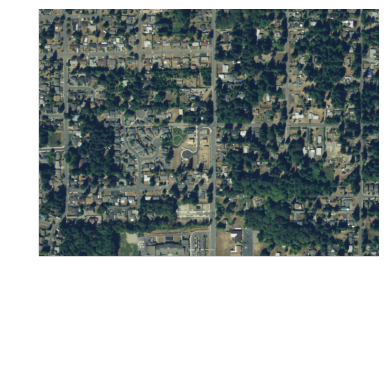

In [19]:
#seeing 1st image
p = df_clean.id[0]
print(p)
from PIL import Image
import matplotlib.pyplot as plt

first_path = f"{IMG_DIR}/{p}"
img = Image.open(first_path)

plt.imshow(img)
plt.axis("off")
plt.show()

making plots for the tabular data to vizualize

In [20]:
# choose numeric columns (except target)
target = "price"
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()

if target in numeric_cols:
    numeric_cols.remove(target)
if "id" in numeric_cols:
    numeric_cols.remove("id")
if "id" in numeric_cols:
    numeric_cols.remove("zipcode")


Scatter Plots

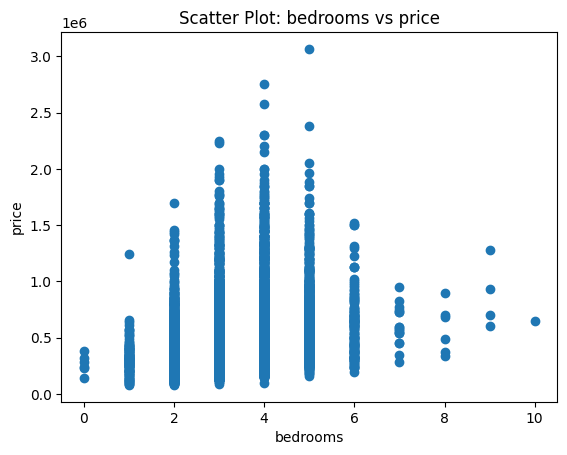

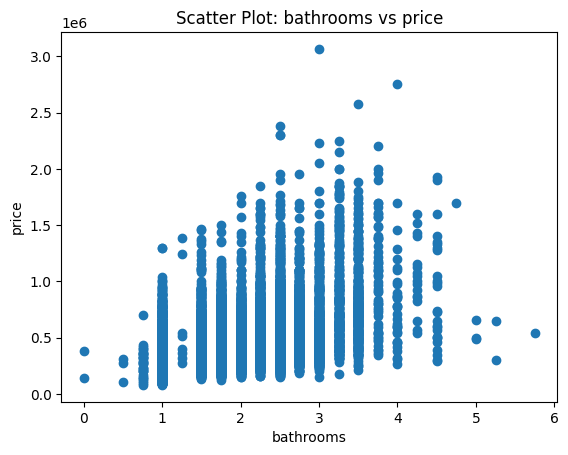

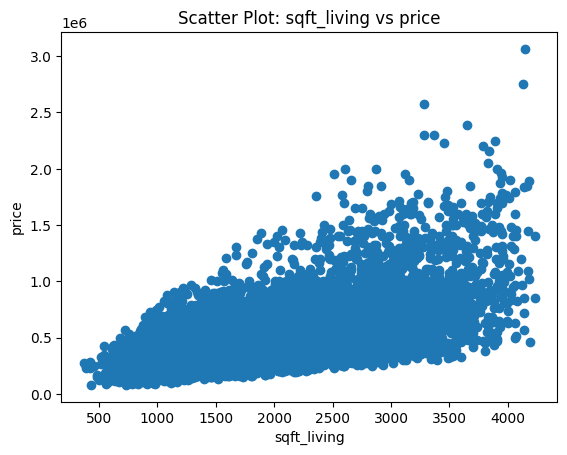

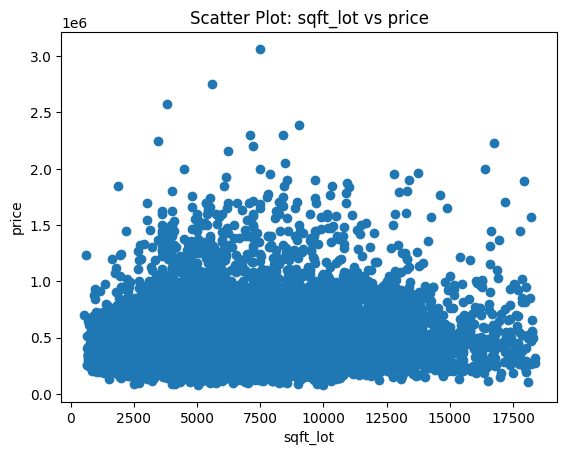

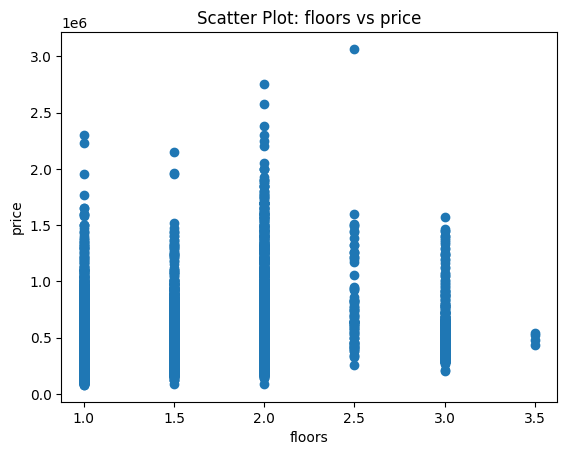

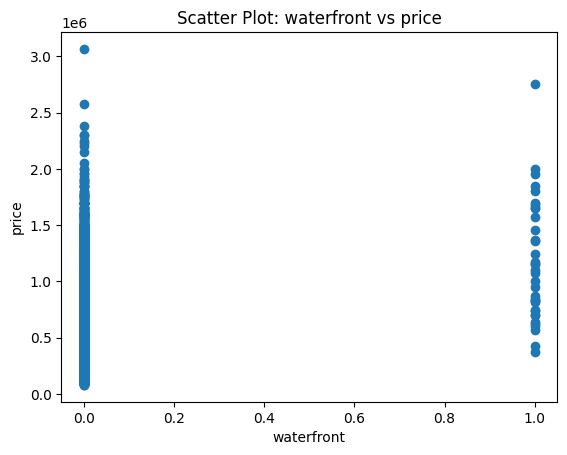

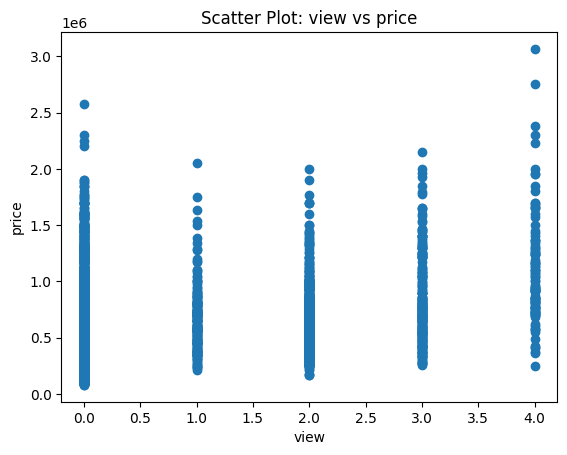

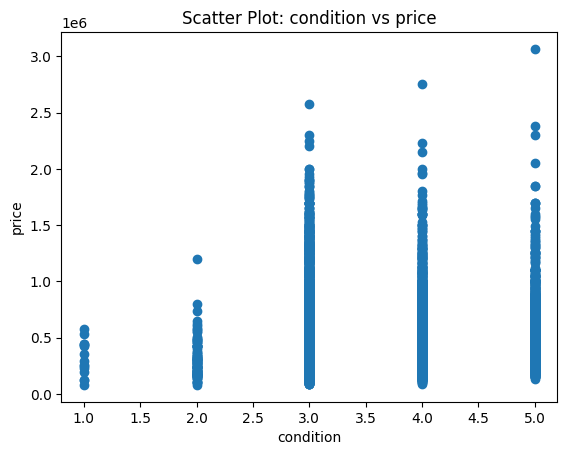

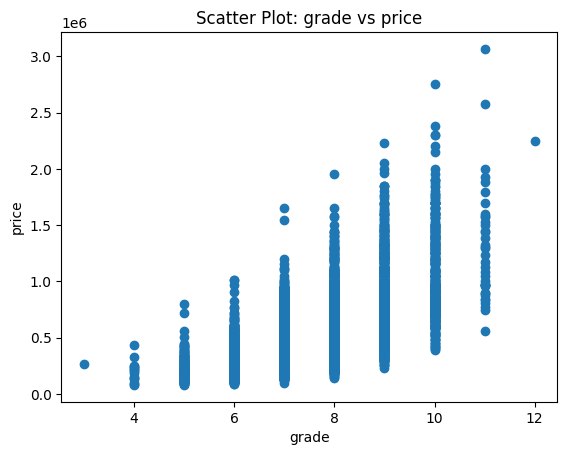

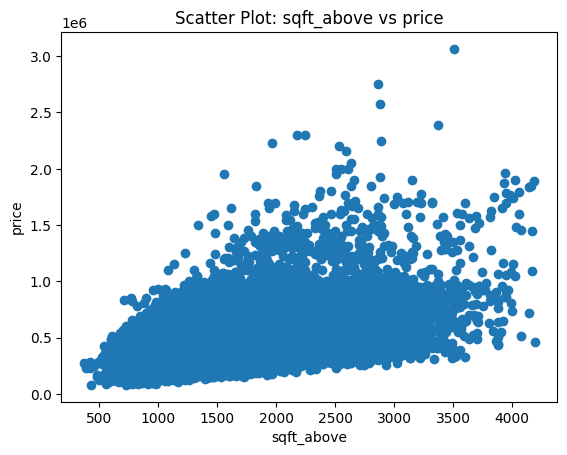

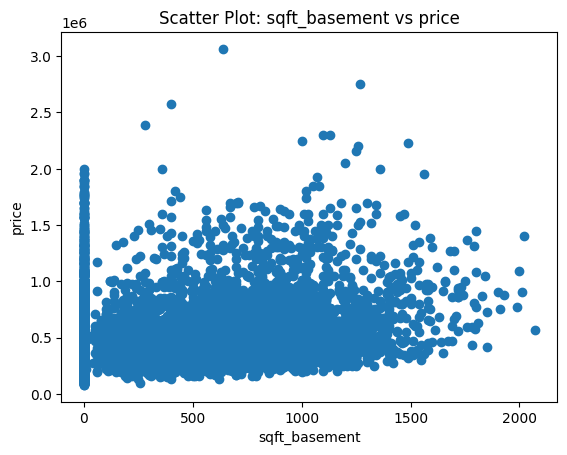

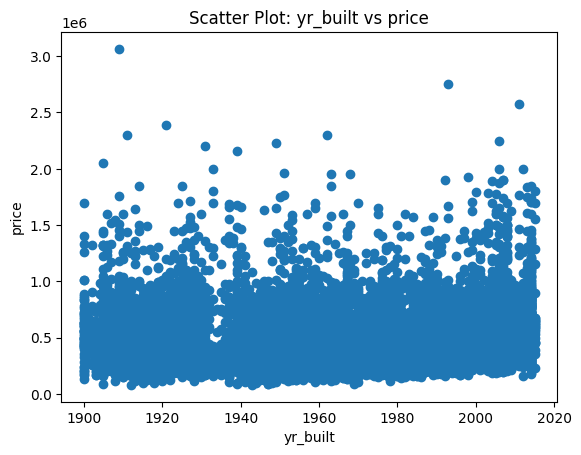

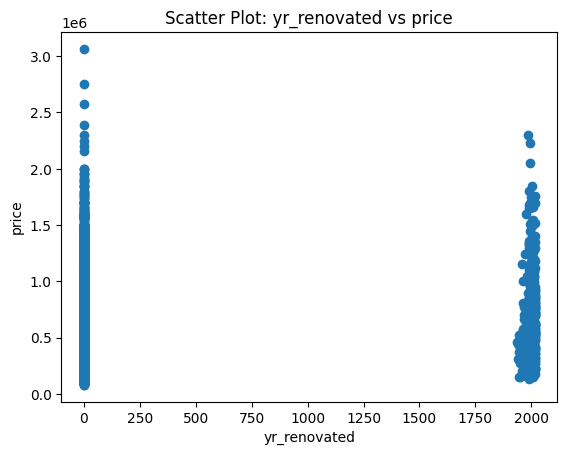

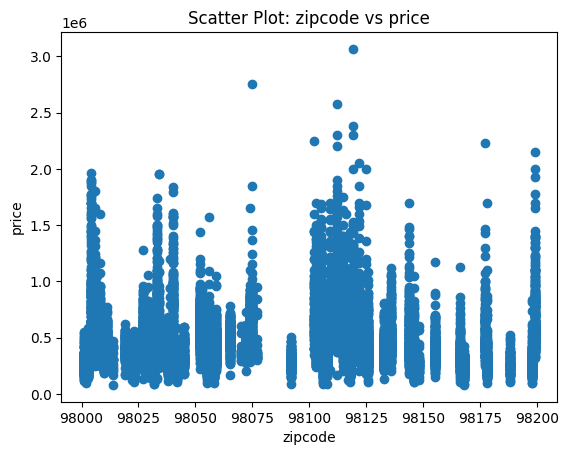

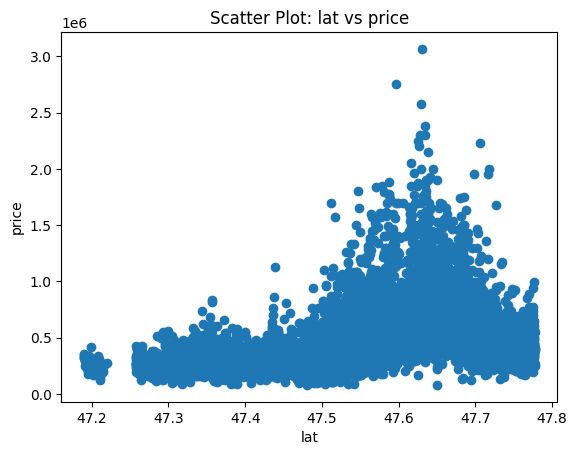

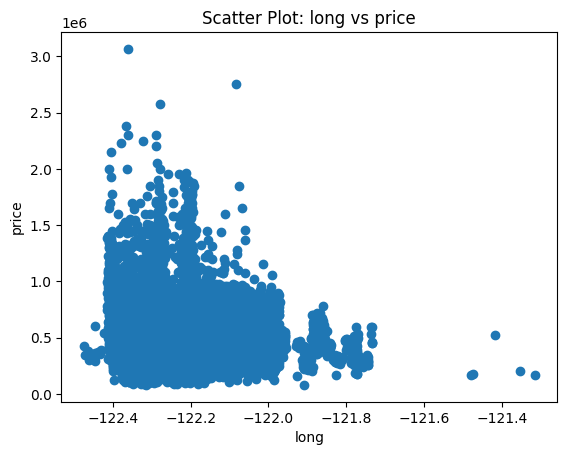

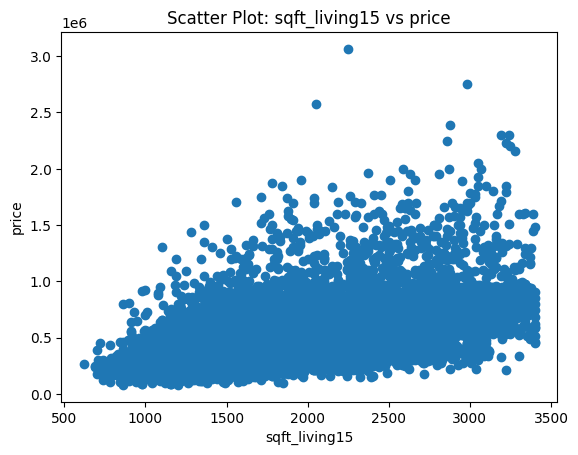

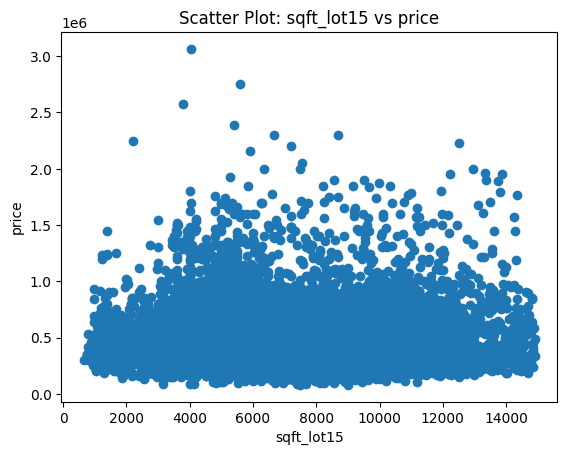

In [21]:

# scatter  plots
for col in numeric_cols:
    plt.figure()
    plt.scatter(df_clean[col], df_clean[target])
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"Scatter Plot: {col} vs {target}")
    plt.show()


Box Plots

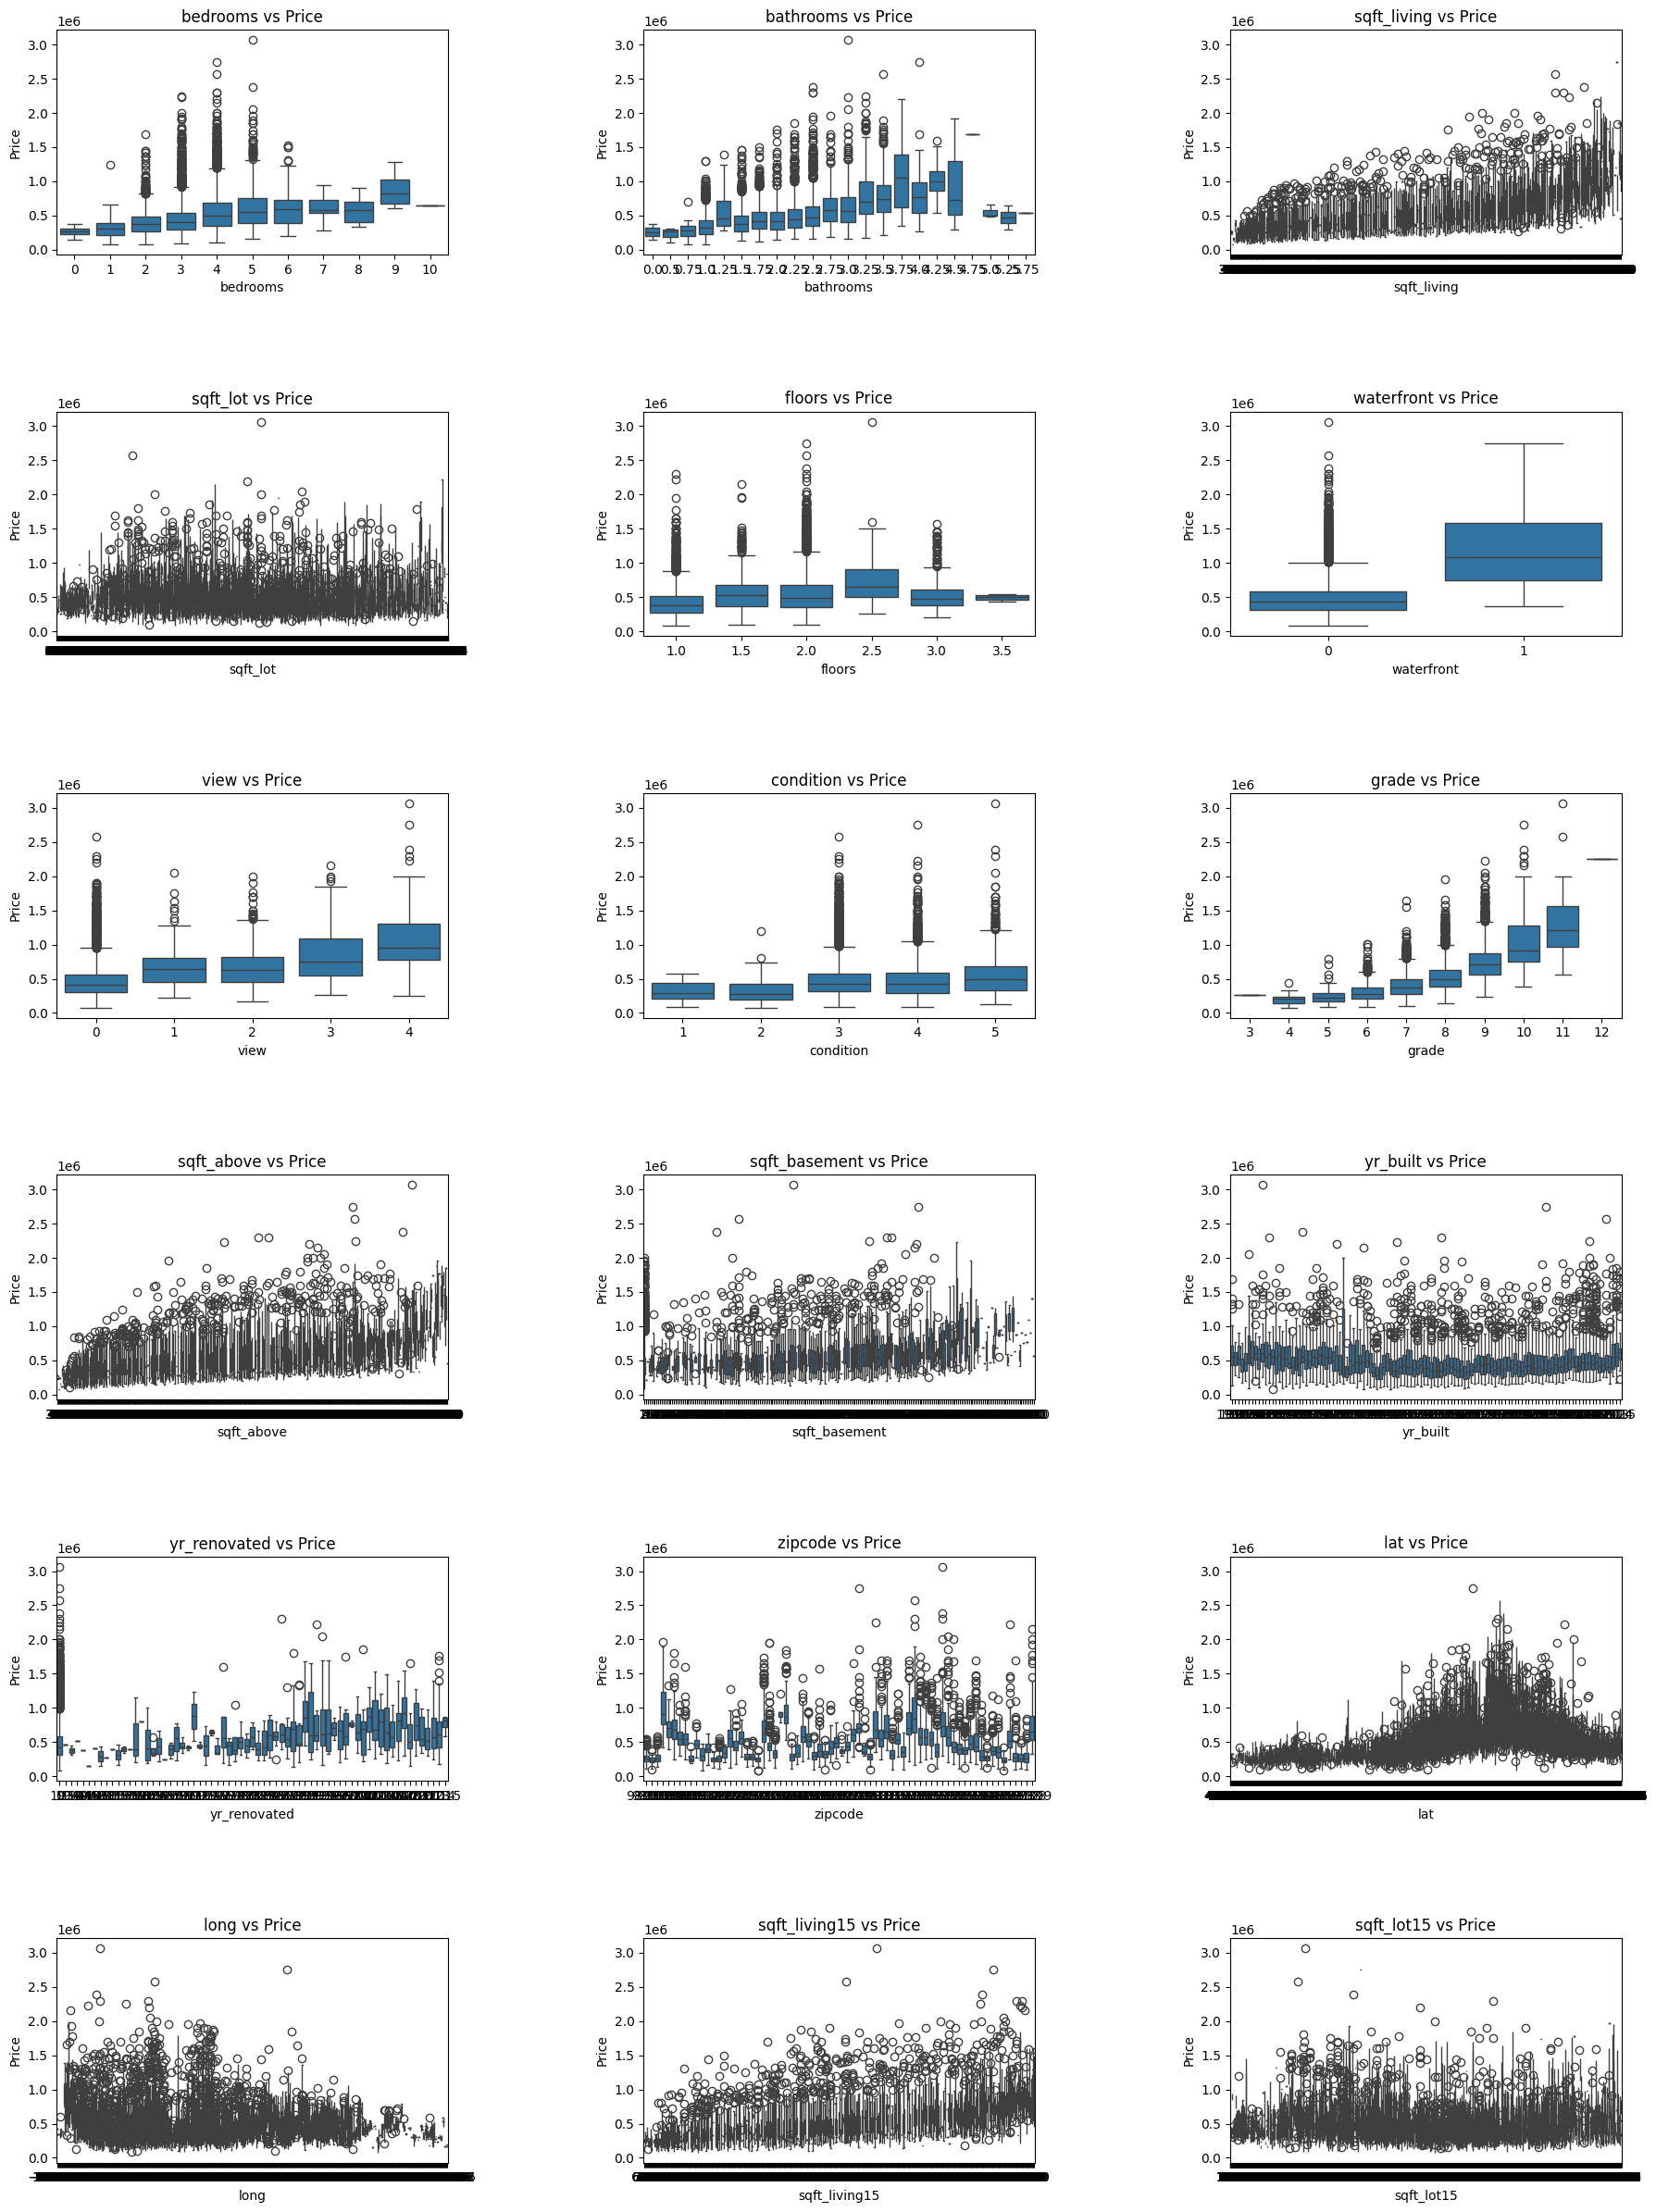

In [22]:
# Box Plots
plt.figure(figsize=(18, 24))

for i, var in enumerate(numeric_cols, 1):
    plt.subplot(6, 3, i)
    sns.boxplot(x=df_clean[var], y=df_clean[target])
    plt.xlabel(var)
    plt.ylabel("Price")
    plt.title(f"{var} vs Price")

plt.tight_layout()
plt.subplots_adjust(hspace=0.7, wspace=0.5)
plt.show()

Now making the correlation matix and finding the correlation value

In [25]:
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(['id', 'zipcode'])
corr_matrix = df_clean[num_cols].corr(method='spearman')

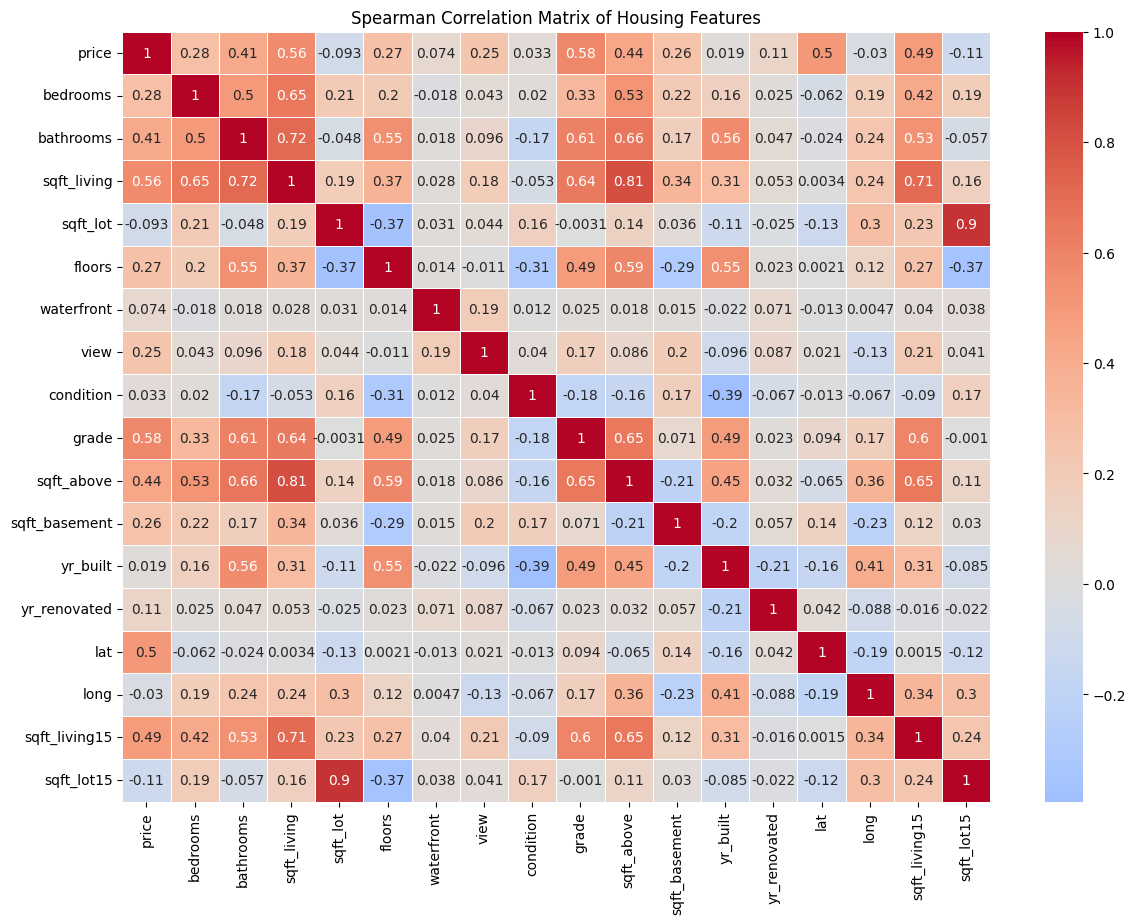

In [26]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Spearman Correlation Matrix of Housing Features")
plt.show()


In [27]:
price_corr = corr_matrix['price'].sort_values(ascending=False)
print(price_corr)


price            1.000000
grade            0.582798
sqft_living      0.562076
lat              0.499633
sqft_living15    0.487227
sqft_above       0.438921
bathrooms        0.412588
bedrooms         0.282096
floors           0.274941
sqft_basement    0.262860
view             0.247522
yr_renovated     0.113543
waterfront       0.073585
condition        0.032695
yr_built         0.018626
long            -0.029663
sqft_lot        -0.092764
sqft_lot15      -0.108912
Name: price, dtype: float64


In [28]:
#correcting the index value of final data ie df_clean
df_clean = df_clean.reset_index(drop=True)


First calculating the RMSE and R2 for only tabular data

In [29]:
y = df_clean["price"].values
X_tab = df_clean.drop(columns=["price", "id", "date", "zipcode"])   # not considering id, date and zipcode for training the model
image_ids = df_clean["id"].values


Now data splitting
1. 70% training
2. 15% val
3. 15% test



In [30]:
# First split: train + temp
train_idx, temp_idx = train_test_split(
    df_clean.index, test_size=0.30, random_state=42
)

# Second split: val + test
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, random_state=42
)


In [31]:
# scales the tabular input features to have mean 0 and standard deviation 1
scaler = StandardScaler()

X_train_tab = scaler.fit_transform(X_tab.iloc[train_idx])
X_val_tab   = scaler.transform(X_tab.iloc[val_idx])
X_test_tab  = scaler.transform(X_tab.iloc[test_idx])

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]


In [32]:
# Trains a Random Forest on training data, predicts on validation data, and computes RMSE and R²
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_tab, y_train)

val_preds = rf.predict(X_val_tab)

rmse_tab = np.sqrt(mean_squared_error(y_val, val_preds))
r2_tab = r2_score(y_val, val_preds)

rmse_tab, r2_tab


(np.float64(94992.1143024817), 0.8477196726790723)

Now training the model on both trabular data and images

In [33]:
#Seting the image size to 128×128 and batch size to 64 for model training
IMG_SIZE = 128
BATCH_SIZE = 64


In [34]:
#Loading an image by ID, resizes it to 128×128, normalizes pixel values to [0,1], and returns it
def load_image(img_id):
    img_path = tf.strings.join(
        [IMG_DIR, "/", tf.strings.as_string(img_id)]
    )
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img


In [35]:
#Createing a TensorFlow dataset of images, tabular features, and labels, applies preprocessing, batches, caches, and prefetches it for training or evaluation
def make_dataset(indices, training=True):
    ids = image_ids[indices]
    tab = X_tab.iloc[indices].values
    labels = y[indices]

    ds = tf.data.Dataset.from_tensor_slices((ids, tab, labels))

    def process(img_id, tabular, label):
        img = load_image(img_id)
        return {"image": img, "tabular": tabular}, label

    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


In [36]:
#Preparing training, validation, and test datasets with images, tabular data, and labels for model input
train_ds = make_dataset(train_idx, training=True)
val_ds   = make_dataset(val_idx, training=False)
test_ds  = make_dataset(test_idx, training=False)


In [37]:
#Loading a pretrained ResNet50 without the top layer and freezes its weights for feature extraction
cnn_base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
cnn_base.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
#Building the image branch: feeds input through ResNet50, pools features, and adds a 256-unit dense layer
from tensorflow.keras import layers, models

image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image")
x = cnn_base(image_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)


In [39]:
#Building the tabular branch with two dense layers of 128 and 64 units
tab_input = layers.Input(shape=(X_tab.shape[1],), name="tabular")
t = layers.Dense(128, activation="relu")(tab_input)
t = layers.Dense(64, activation="relu")(t)


In [40]:
#Combining image and tabular branches, adds dense layers, and creates a single-output model
combined = layers.concatenate([x, t])
z = layers.Dense(128, activation="relu")(combined)
z = layers.Dense(64, activation="relu")(z)
output = layers.Dense(1)(z)

model = models.Model(
    inputs=[image_input, tab_input],
    outputs=output
)


In [41]:
#Compiling the model with Adam optimizer, MSE loss, RMSE metric, and displays its summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ image[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular             │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,304 │ tabular[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     41,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,172,225 (92.21 MB)

 Trainable params: 584,513 (2.23 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [42]:
#Training the model on the training dataset for 10 epochs and evaluates on the validation set.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1934s 13s/step - loss: 203383259136.0000 - root_mean_squared_error: 444872.4688 - val_loss: 40346914816.0000 - val_root_mean_squared_error: 200865.4219
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - loss: 40713375744.0000 - root_mean_squared_error: 201640.4375 - val_loss: 35152986112.0000 - val_root_mean_squared_error: 187491.2969
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - loss: 38126497792.0000 - root_mean_squared_error: 195215.7969 - val_loss: 34801709056.0000 - val_root_mean_squared_error: 186552.1562
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - loss: 37689978880.0000 - root_mean_squared_error: 194097.8125 - val_loss: 34544472064.0000 - val_root_mean_squared_error: 185861.4375
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - loss: 37376081920.0000 - root_mean_squared_error: 193290.2500 - val_loss: 34326085632.0000 - val_root_mean_squared_error: 185273.0000
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step

In [43]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

In [44]:
test_loss, test_rmse = model.evaluate(test_ds)
test_rmse

32/32 ━━━━━━━━━━━━━━━━━━━━ 347s 11s/step - loss: 38952239104.0000 - root_mean_squared_error: 197134.5625


196494.125

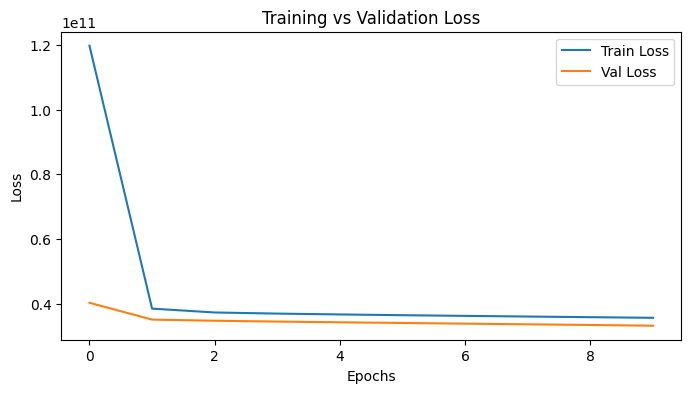

In [45]:
# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

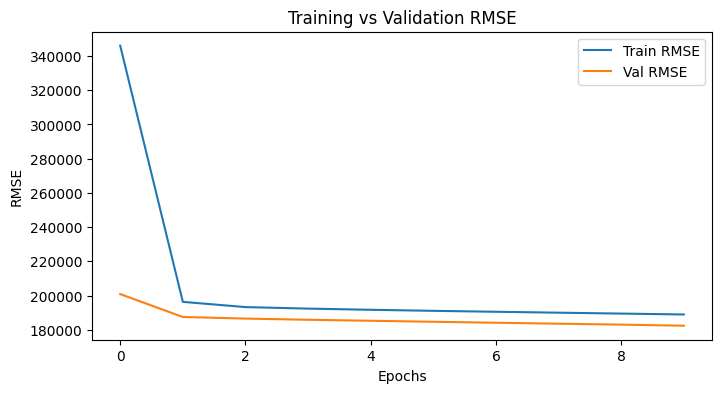

In [46]:
#model’s training RMSE and validation RMSE change over epochs
plt.figure(figsize=(8,4))
plt.plot(history.history["root_mean_squared_error"], label="Train RMSE")
plt.plot(history.history["val_root_mean_squared_error"], label="Val RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE")
plt.legend()
plt.show()


In [47]:
#checking how well the model performs on unseen test data
test_loss, test_rmse = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)

32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 38952239104.0000 - root_mean_squared_error: 197134.5625
Test Loss: 38609940480.0
Test RMSE: 196494.125


In [48]:
#calculating R2 score

# true prices from test dataset
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# model predictions
y_pred = model.predict(test_ds).reshape(-1)

# R2 score
print("R2:", r2_score(y_true, y_pred))


32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step
R2: 0.4266189932823181


Now saving the complete model

In [144]:
import joblib

# 1. Save the Multi-Modal Neural Network (Images + Tabular)
model.save(f"{PROJECT_DIR}/final_model_multimodal.keras")

# 2. Save the Random Forest (Tabular Only)
joblib.dump(rf, f"{PROJECT_DIR}/final_model_rf.joblib")

# 3. Save the Scaler (REQUIRED to process the test.csv correctly)
joblib.dump(scaler, f"{PROJECT_DIR}/final_scaler.joblib")

print("All models and preprocessing objects saved successfully!")

All models and preprocessing objects saved successfully!


In [145]:
#GRAD-CAM function
import cv2


def get_gradcam_heatmap(backbone_model, img_array, last_conv_layer_name):
    # This creates a model specifically for the backbone's internal layers
    grad_model = tf.keras.Model(
        inputs=backbone_model.inputs,
        outputs=backbone_model.get_layer(last_conv_layer_name).output
    )

    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_array)
        loss = tf.reduce_mean(conv_outputs)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy()

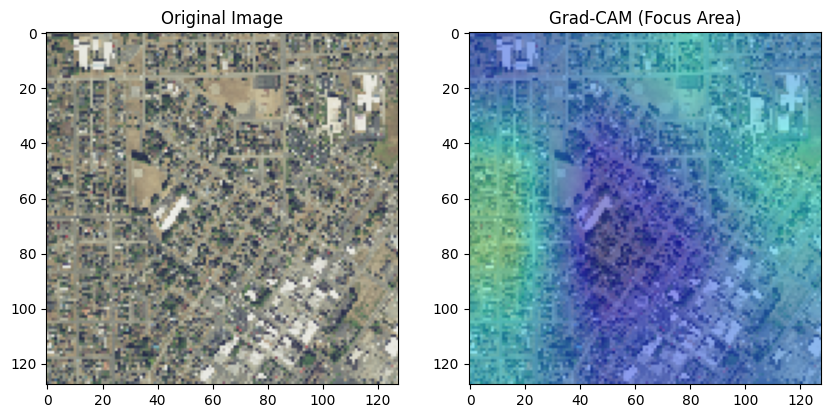

In [146]:
# 1. Get the actual ResNet sub-model from your main model
resnet_backbone = model.get_layer("resnet50")

# 2. Grab a sample image from your validation set
for batch in val_ds.take(1):
    inputs, _ = batch
sample_image = inputs["image"][0:1] # Take the first image in the batch

# 3. Generate the heatmap
heatmap = get_gradcam_heatmap(
    backbone_model=resnet_backbone,
    img_array=sample_image,
    last_conv_layer_name="conv5_block3_out"
)

# 4. OVERLAY logic: Make the visualization readable
heatmap_resized = cv2.resize(heatmap, (128, 128)) # Resize to image dimensions
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Convert original image to 0-255 scale for merging
original_img = np.uint8(255 * sample_image[0])

# Merge image and heatmap
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

# 5. Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image[0])

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (Focus Area)")
plt.imshow(superimposed_img)
plt.show()

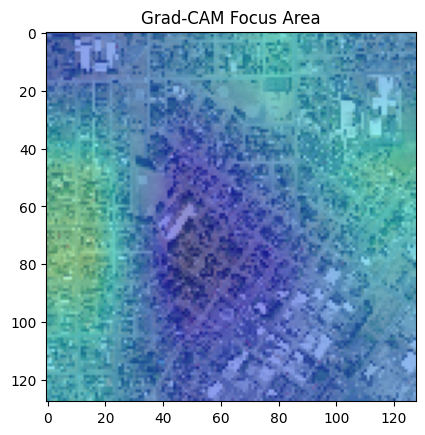

In [147]:
#Overlaying the Heatmap
import cv2

# Resize heatmap to match original image size
heatmap_resized = cv2.resize(heatmap, (128, 128))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose
img = np.uint8(255 * sample_image[0])
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

plt.imshow(superimposed_img)
plt.title("Grad-CAM Focus Area")
plt.show()

In [148]:
#GET THE RESNET BACKBONE
resnet = model.get_layer("resnet50")


In [149]:
#GRAD-CAM function

import cv2
def emergency_gradcam(resnet_model, img_tensor):
    img_tensor = tf.cast(img_tensor, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        conv_outputs = resnet_model(img_tensor, training=False)
        loss = tf.reduce_mean(conv_outputs)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()


In [150]:
#extract image and run
for batch in val_ds.take(1):
    inputs, _ = batch

sample_image = inputs["image"][0:1]

heatmap = emergency_gradcam(resnet, sample_image)


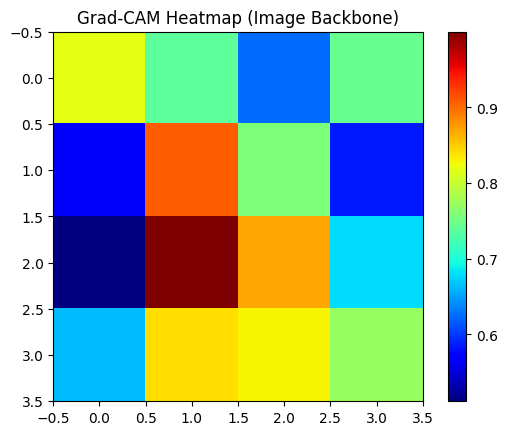

In [151]:
#visual check

plt.imshow(heatmap, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM Heatmap (Image Backbone)")
plt.show()


Geospatial Analysis:

maps (using lat and long) showing price distributions across the region

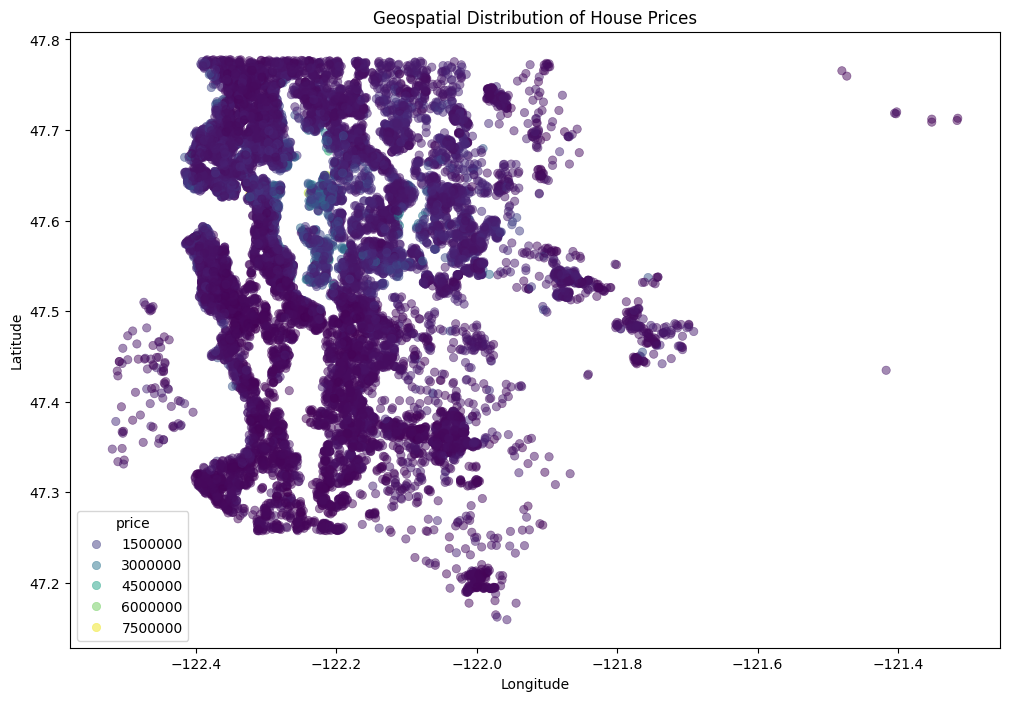

In [152]:
#Static Heatmap (Using Seaborn)

plt.figure(figsize=(12, 8))
# We use 'price' as the hue to color the points based on value
sns.scatterplot(data=df_latest, x='long', y='lat', hue='price',
                palette='viridis', alpha=0.5, edgecolor=None)
plt.title('Geospatial Distribution of House Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

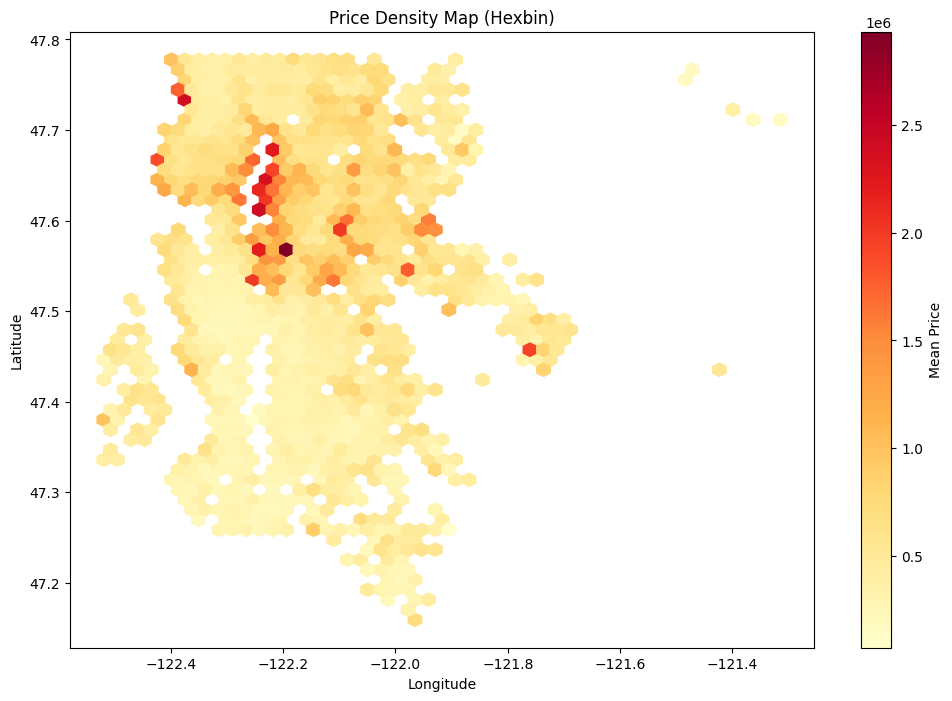

In [154]:
#Density Map (To identify high density areas)
plt.figure(figsize=(12, 8))
plt.hexbin(df_latest['long'], df_latest['lat'], C=df_latest['price'],
           gridsize=50, cmap='YlOrRd')
plt.colorbar(label='Mean Price')
plt.title('Price Density Map (Hexbin)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()